In [16]:
import os
from tqdm import tqdm
import json
import argparse
import pickle
import torch
import torch.nn as nn
import numpy as np
import pprint
from tensorboardX import SummaryWriter
import re
import gc
import sys
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from numpy.linalg import svd
from mpl_toolkits.mplot3d import Axes3D
import time
import yaml

sys.path = ['..'] + sys.path
from algorithm_trainer.models import gated_conv_net_original, resnet, resnet_2, resnet_12, conv64
from algorithm_trainer.algorithm_trainer import Generic_adaptation_trainer, Classical_algorithm_trainer
from algorithm_trainer.algorithms.algorithm import SVM, ProtoNet, Finetune, ProtoCosineNet
from algorithm_trainer.utils import accuracy
from data_layer.dataset_managers import MetaDataManager, ClassicalDataManager
from analysis.objectives import var_reduction_disc, var_reduction_disc_perp, var_reduction

%matplotlib inline

In [21]:
def load_model(checkpoint):
    
    if model_type == 'resnet12':
        if dataset_path.split('/')[-1] in ['miniImagenet', 'CUB']:
            model = resnet_12.resnet12(avg_pool=(avg_pool == "True"), drop_rate=0.1, dropblock_size=5,
            no_fc_layer=True, projection=(projection=="True"))
        else:
            model = resnet_12.resnet12(avg_pool=(avg_pool == "True"), drop_rate=0.1, dropblock_size=2,
            no_fc_layer=True, projection=(projection=="True"))
    else:
        model = conv64.Conv64(num_classes=None,
                classifier_type=None, no_fc_layer=True, projection=(projection=="True"))
            
    print(f"loading from {checkpoint}")
    model_dict = model.state_dict()
    chkpt_state_dict = torch.load(checkpoint)
    if 'model' in chkpt_state_dict:
        chkpt_state_dict = chkpt_state_dict['model']
    chkpt_state_dict_cpy = chkpt_state_dict.copy()
    # remove "module." from key, possibly present as it was dumped by data-parallel
    for key in chkpt_state_dict_cpy.keys():
        if 'module.' in key:
            new_key = re.sub('module\.', '',  key)
            chkpt_state_dict[new_key] = chkpt_state_dict.pop(key)
    chkpt_state_dict = {k: v for k, v in chkpt_state_dict.items() if k in model_dict}
    model_dict.update(chkpt_state_dict)
    updated_keys = set(model_dict).intersection(set(chkpt_state_dict))
    missed_keys = set(model_dict).difference(set(chkpt_state_dict))
    print(f"Missed {len(missed_keys)} keys")
    model.load_state_dict(model_dict)
    model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
    model.cuda()
    return model

# step 1: Fix 10 different random support sets

In [22]:
img_side_len = 84
n_way_train = 5
n_shot_train = 5
n_query_train = 15
n_query_pool = 15
batch_size_train = 4
support_aug = False
train_aug = False
n_episodes = 125
n_curves = 10
log_interval = 2000
model_type = 'resnet12'
avg_pool = "False"
projection = "False"
dataset_path = '../data/filelists/miniImagenet'
model_type = 'conv64'
model_path = '../train_dir_2/fixS5_conv64_r12_n20_s5_q15_qp15_bs1_euc_drop20'

In [10]:
def fetch_loader(seed=None, n_episodes=250, fix_support=0):
    if seed is not None:
        print("Setting seed to", seed)
        np.random.seed(seed)
    image_size = img_side_len
    train_file = os.path.join(dataset_path, 'base.json')
    mt_datamgr = MetaDataManager(
        image_size, batch_size=batch_size_train, n_episodes=n_episodes,
        n_way=n_way_train, n_shot=n_shot_train, n_query=max(n_query_train, n_query_pool), fix_support=fix_support)
    mt_loader = mt_datamgr.get_data_loader(
        dataset_path.split('/')[-1], train_file, support_aug=support_aug, query_aug=train_aug)
    if seed is not None:
        import time
        t = 1000 * time.time() # current time in milliseconds
        np.random.seed(int(t) % 2**32)
        print("Resetting random seed")
    return (mt_loader, mt_datamgr)

In [11]:
def read_random_seed(model_path):
    with open(os.path.join(model_path, 'config.txt')) as f:
        for line in f.readlines():
            line = line.strip('\n')
            if 'random_seed' in line:
                return int(line.split(":")[-1])
    return None

In [12]:
%%capture
random_fixed_support_loaders = [fetch_loader(n_episodes=n_episodes, fix_support=n_shot_train) for _ in range(n_curves)]

In [13]:
vanilla_meta_loader = fetch_loader(n_episodes=500)

support aug: False query aug: False
Support set is fixed: False


In [14]:
specific_support_loader = fetch_loader(seed=read_random_seed(model_path), n_episodes=n_episodes, fix_support=n_shot_train)

Setting seed to 0
support aug: False query aug: False
Support set is fixed: True
Resetting random seed


# step 2: Load models and evaluate objectives

In [15]:
def evaluate(train_loader, model):
    algorithm = ProtoNet(
        model=model,
        inner_loss_func=torch.nn.CrossEntropyLoss(),
        n_way=n_way_train,
        n_shot=n_shot_train,
        n_query=n_query_train,
        device='cuda')
    trainer = Generic_adaptation_trainer(
        algorithm=algorithm,
        aux_objective=None,
        outer_loss_func=torch.nn.CrossEntropyLoss(),
        outer_optimizer=None, 
        writer=None,
        log_interval=log_interval,
        model_type=model_type)
    with torch.no_grad():
        results = trainer.run(*(train_loader))
    return results

In [ ]:
train_loss = defaultdict(list)
r = re.compile(".*pt")
for modelfile in sorted(list(filter(r.match, os.listdir(model_path)))):
    print("**"*50)
    print("loading", modelfile)
    modelfile = os.path.join(model_path, modelfile)
    model = load_model(modelfile)
    for i in range(len(random_fixed_support_loaders)):
        print("--"*20)
        print("Evaluating on random support ", i+1)
        train_loss["random_" + str(i)].append(evaluate(random_fixed_support_loaders[i], model))
    print("--"*20)
    print("Evaluating on specific support ")
    train_loss['specific'].append(evaluate(specific_support_loader, model))
    train_loss['avg'].append(evaluate(vanilla_meta_loader, model))
    print("Saving results ")
    with open("train_analysis_run_"+model_path.split('/')[-1]+".pkl", 'wb') as f:
        torch.save(train_loss, f)

****************************************************************************************************
loading classical_resnet_001.pt
Unit norm projection is  False
loading from ../train_dir_2/fixS5_conv64_r12_n20_s5_q15_qp15_bs1_euc_drop20/classical_resnet_001.pt
Missed 0 keys
----------------------------------------
Evaluating on random support  1
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 4
Setting scale to  tensor([10.3515], device='cuda:0')
62it [04:09,  7.84s/it]

# step 3: plots

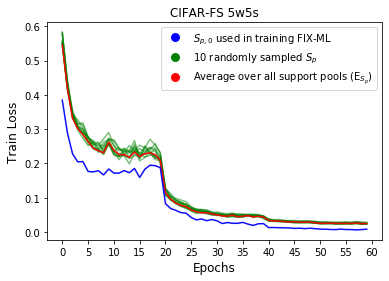

In [9]:
train_loss = torch.load('train_analysis_run_fixS5_cifar_r12_n20_s5_q15_qp50_euc_run2.pkl')
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Create the figure
fig, ax = plt.subplots()

for k in range(0, 10):
    values = [train_loss["random_"+str(k)][x]['test_loss_after']['loss'] for x in range(len(train_loss["random_"+str(k)]))]
    ax.plot(np.arange(len(values)), values, color="g", alpha=0.5)
values = [train_loss['avg'][x]['test_loss_after']['loss'] for x in range(len(train_loss['avg']))]
ax.plot(np.arange(len(values)), values, color="r", alpha=0.95)
values = [train_loss['specific'][x]['test_loss_after']['loss'] for x in range(len(train_loss['avg']))]
ax.plot(np.arange(len(values)), values, color="b", alpha=0.95)

ax.set_ylabel("Train Loss", size=12)
ax.set_xlabel("Epochs", size=12)
# ax.set_xticks(np.arange(0, 61))
# ax.set_xticklabels([str(x) for x in np.arange(0, 61)])
ax.set_xticks(np.arange(0, len(train_loss["avg"])+5, 5))

legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='$S_{p,0}$ used in training FIX-ML',
                          markerfacecolor='b', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='10 randomly sampled $S_{p}$',
                          markerfacecolor='g', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Average over all support pools $(\mathrm{E}_{S_p})$',
                          markerfacecolor='r', markersize=10)]

ax.legend(handles=legend_elements, loc='upper right')
plt.title('CIFAR-FS 5w5s')
# plt.show()
plt.savefig('CIFAR-FS-5w5s-trajectory.pdf')